<a href="https://colab.research.google.com/github/hannanote/Subway_Congestion_Forecast_Analysis/blob/main/Congestion_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install koreanize-matplotlib
import koreanize_matplotlib
!pip install holidays
from sklearn.model_selection import train_test_split
from sklearn import metrics
!pip install tensorflow
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import holidays
import os
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc
import platform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 122.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing ins

In [3]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_subway_merged_ext_data.csv', encoding='cp949')
df1.head()

,tm,line,station_number,station_name,direction,stn,ta,wd,ws,rn_day,rn_hr1,hm,si,ta_chi,congestion,entrances,transfer_count
0,2021010100,1,150,서울역,상선,419,-9.6,291.1,3.3,0.0,0.0,-99.0,-99.0,-12.6,0,9,3
1,2021010101,1,150,서울역,상선,419,-9.7,284.6,2.0,0.0,0.0,-99.0,-99.0,-9.8,0,9,3
2,2021010105,1,150,서울역,상선,419,-9.3,124.7,2.4,0.0,0.0,-99.0,-99.0,-10.3,1,9,3
3,2021010106,1,150,서울역,상선,419,-9.3,126.2,1.7,0.0,0.0,-99.0,-99.0,-10.1,2,9,3
4,2021010107,1,150,서울역,상선,419,-9.1,145.7,1.3,0.0,0.0,-99.0,-99.0,-9.7,3,9,3


In [4]:
df1.drop(['si', 'transfer_count'], axis=1, inplace=True)
#df1

In [5]:
# 조건별로 변경
stations = ['창동', '충무로', '신내', '군자', '천호', '연신내']
df1.loc[(df1['station_name'] == '창동') & (df1['entrances'] == 0), 'entrances'] = 2
df1.loc[(df1['station_name'] == '충무로') & (df1['entrances'] == 0), 'entrances'] = 8
df1.loc[(df1['station_name'] == '신내') & (df1['entrances'] == 0), 'entrances'] = 4
df1.loc[(df1['station_name'] == '군자') & (df1['entrances'] == 0), 'entrances'] = 8
df1.loc[(df1['station_name'] == '천호') & (df1['entrances'] == 0), 'entrances'] = 10
df1.loc[(df1['station_name'] == '연신내') & (df1['entrances'] == 0), 'entrances'] = 7
#df1[df1['station_name'].isin(stations)].groupby('station_name')['entrances'].value_counts()

In [6]:
missing_cols = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'ta_chi']

# 각 컬럼에서 -99 값을 np.nan으로 변환
df1[missing_cols] = df1[missing_cols].replace(-99.0, np.nan)
df1['wd'] = df1['wd'].replace(-9.9, np.nan)
#df['hm'] = df['hm'].interpolate()
#print(df1.isnull().sum())

# 분석용 변수 목록 (si 제외)
valid_cols = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'ta_chi']

# 결측치 제거
df1 = df1.dropna(subset=valid_cols)
df1.isnull().sum()

,0
tm,0
line,0
station_number,0
station_name,0
direction,0
stn,0
ta,0
wd,0
ws,0
rn_day,0


In [7]:
df1['tm'] = pd.to_datetime(df1['tm'], format='%Y%m%d%H')
df1['hour'] = df1['tm'].dt.hour
df1['month'] = df1['tm'].dt.month
#df1['date'] = df1['tm'].dt.date
df1['weekday'] = df1['tm'].dt.weekday

# 공휴일 객체 생성
kr_holidays = holidays.KR(years=df1['tm'].dt.year.unique())

# 날짜만 추출해 공휴일 여부 확인
df1['is_holiday'] = df1['tm'].dt.date.isin(kr_holidays)

# 3. 분류
def classify_day(row):
    if row['is_holiday']:
        return '공휴일'
    elif row['weekday'] == 6:
        return '일요일'
    elif row['weekday'] == 5:
        return '토요일'
    else:
        return '평일'

df1['day_type'] = df1.apply(classify_day, axis=1)

# 결과 확인
df1['day_type'].value_counts()

,count
day_type,
평일,10798926
일요일,2163732
토요일,2140862
공휴일,786152


In [8]:
# 선형 보간 함수 정의
def linear_interpolate_per_station(group):
    group = group.sort_values('tm')
    group['hm'] = group['hm'].interpolate(method='linear')
    return group

# 보간 적용 + 경고 방지
df1 = df1.groupby('station_name', group_keys=False).apply(linear_interpolate_per_station).reset_index(drop=True)

# 남은 NaN 보완
df1['hm'] = df1['hm'].fillna(method='ffill').fillna(method='bfill')

# 결측치 확인
print("최종 결측치 수:", df1['hm'].isna().sum())

/tmp/ipython-input-8-3172090887.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df1 = df1.groupby('station_name', group_keys=False).apply(linear_interpolate_per_station).reset_index(drop=True)
/tmp/ipython-input-8-3172090887.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df1['hm'] = df1['hm'].fillna(method='ffill').fillna(method='bfill')


최종 결측치 수: 0


In [9]:
# 'tm' 컬럼 삭제
df1 = df1.drop(columns=['tm'])

# 범주형 변수 원-핫 인코딩
df1 = pd.get_dummies(df1, columns=['direction', 'station_name', 'is_holiday', 'day_type'])

# 독립변수(X), 종속변수(Y) 분리
X = df1.drop(columns=['congestion'])
Y = df1['congestion']

In [10]:
# 학습용/테스트용 나누기
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

# 정규화 (Z-score: (X - mean) / std)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_train_scaled_df.describe()

,line,station_number,stn,ta,wd,ws,rn_day,rn_hr1,hm,ta_chi,...,station_name_회기,station_name_회룡,station_name_회현,station_name_효창공원앞,is_holiday_False,is_holiday_True,day_type_공휴일,day_type_일요일,day_type_토요일,day_type_평일
count,1.112277e+07,1.112277e+07,1.112277e+07,1.112277e+07,1.112277e+07,1.112277e+07,1.112277e+07,1.112277e+07,1.112277e+07,1.112277e+07,...,1.112277e+07,1.112277e+07,1.112277e+07,1.112277e+07,1.112277e+07,1.112277e+07,1.112277e+07,1.112277e+07,1.112277e+07,1.112277e+07
mean,-1.190731e-16,-6.246492e-17,-8.620468e-17,3.523851e-15,4.680870e-16,-8.604714e-16,-1.598754e-16,1.115495e-16,-1.863533e-15,-4.503668e-17,...,5.473522e-17,-1.262432e-17,-4.709942e-17,1.359405e-18,1.678469e-16,-3.523721e-17,-3.523721e-17,-5.625624e-17,-4.550685e-17,7.025978e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.414414e+00,-1.313006e+00,-2.340660e+00,-3.544579e+00,-1.799862e+00,-1.352119e+00,-2.210264e-01,-1.261981e-01,-2.950401e+00,-3.415571e+00,...,-5.325074e-02,-5.304575e-02,-5.328384e-02,-5.318873e-02,-4.381040e+00,-2.282563e-01,-2.282563e-01,-3.970018e-01,-3.947965e-01,-1.456002e+00
25%,-9.616423e-01,-1.097200e+00,-1.541959e-01,-7.583365e-01,-8.821309e-01,-7.052364e-01,-2.210264e-01,-1.261981e-01,-7.732263e-01,-7.653933e-01,...,-5.325074e-02,-5.304575e-02,-5.328384e-02,-5.318873e-02,2.282563e-01,-2.282563e-01,-2.282563e-01,-3.970018e-01,-3.947965e-01,-1.456002e+00
50%,-5.609870e-02,1.509763e-01,-7.636058e-02,1.220072e-01,1.262046e-01,-2.200741e-01,-2.210264e-01,-1.261981e-01,4.997736e-03,1.069221e-01,...,-5.325074e-02,-5.304575e-02,-5.328384e-02,-5.318873e-02,2.282563e-01,-2.282563e-01,-2.282563e-01,-3.970018e-01,-3.947965e-01,6.868124e-01
75%,8.494449e-01,7.567333e-01,3.685440e-02,8.389882e-01,8.627280e-01,5.076693e-01,-2.210264e-01,-1.261981e-01,8.527061e-01,8.629287e-01,...,-5.325074e-02,-5.304575e-02,-5.328384e-02,-5.318873e-02,2.282563e-01,-2.282563e-01,-2.282563e-01,-3.970018e-01,-3.947965e-01,6.868124e-01
max,1.754988e+00,6.066065e+00,3.256406e+00,2.336480e+00,1.707392e+00,1.207070e+01,3.912380e+01,1.027340e+02,1.630930e+00,1.942938e+00,...,1.877908e+01,1.885165e+01,1.876742e+01,1.880098e+01,2.282563e-01,4.381040e+00,4.381040e+00,2.518880e+00,2.532950e+00,6.868124e-01


In [ ]:
X_train_scaled.shape[1]

348

In [11]:
import tensorflow.keras.backend as K
Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model = Sequential()
model.add(Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint_callback = ModelCheckpoint(
    filepath='./best_model_mse.keras',
    monitor='val_loss',
    save_best_only=True
)

history = model.fit(
    X_train_scaled, Y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping_callback, model_checkpoint_callback]
)

# 테스트 데이터에 RMSE 계산
from sklearn.metrics import mean_squared_error
import numpy as np

Y_pred = model.predict(X_test_scaled).flatten()
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print(f"Test RMSE: {test_rmse:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
69518/69518 ━━━━━━━━━━━━━━━━━━━━ 158s 2ms/step - loss: 111.6348 - rmse: 10.1256 - val_loss: 60.3128 - val_rmse: 7.6695
Epoch 2/100
69518/69518 ━━━━━━━━━━━━━━━━━━━━ 153s 2ms/step - loss: 57.6242 - rmse: 7.5001 - val_loss: 55.0788 - val_rmse: 7.3310
Epoch 3/100
69518/69518 ━━━━━━━━━━━━━━━━━━━━ 151s 2ms/step - loss: 53.5329 - rmse: 7.2229 - val_loss: 51.3380 - val_rmse: 7.0705
Epoch 4/100
69518/69518 ━━━━━━━━━━━━━━━━━━━━ 150s 2ms/step - loss: 51.4353 - rmse: 7.0804 - val_loss: 50.5981 - val_rmse: 7.0177
Epoch 5/100
69518/69518 ━━━━━━━━━━━━━━━━━━━━ 150s 2ms/step - loss: 50.1049 - rmse: 6.9864 - val_loss: 48.9825 - val_rmse: 6.9003
Epoch 6/100
69518/69518 ━━━━━━━━━━━━━━━━━━━━ 151s 2ms/step - loss: 49.3013 - rmse: 6.9245 - val_loss: 48.6175 - val_rmse: 6.8756
Epoch 7/100
69518/69518 ━━━━━━━━━━━━━━━━━━━━ 150s 2ms/step - loss: 48.4263 - rmse: 6.8629 - val_loss: 47.9581 - val_rmse: 6.8267
Epoch 8/100
69518/69518 ━━━━━━━━━━━━━━━━━━━━ 151s 2ms/step - loss: 47.7201 - rmse: 6.8143 - val

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

MSE: 43.2577
RMSE: 6.5771
MAE: 4.3546


In [19]:
from sklearn.metrics import r2_score
r2 = r2_score(Y_test, Y_pred)
print(f"R² (결정계수): {r2:.4f}")

R² (결정계수): 0.8856


In [14]:
for i in range(10):
    label = Y_test.iloc[i]
    prediction = Y_pred[i]
    error = abs(label - prediction)
    print(f"실제혼잡도: {label:.1f}, 예상혼잡도: {prediction:.1f}, 오차: {error:.1f}")


실제혼잡도: 0.0, 예상혼잡도: 0.4, 오차: 0.4
실제혼잡도: 54.0, 예상혼잡도: 62.6, 오차: 8.6
실제혼잡도: 18.0, 예상혼잡도: 11.7, 오차: 6.3
실제혼잡도: 11.0, 예상혼잡도: 10.4, 오차: 0.6
실제혼잡도: 33.0, 예상혼잡도: 34.8, 오차: 1.8
실제혼잡도: 0.0, 예상혼잡도: -0.0, 오차: 0.0
실제혼잡도: 12.0, 예상혼잡도: 18.3, 오차: 6.3
실제혼잡도: 15.0, 예상혼잡도: 36.8, 오차: 21.8
실제혼잡도: 2.0, 예상혼잡도: 2.9, 오차: 0.9
실제혼잡도: 95.0, 예상혼잡도: 46.3, 오차: 48.7


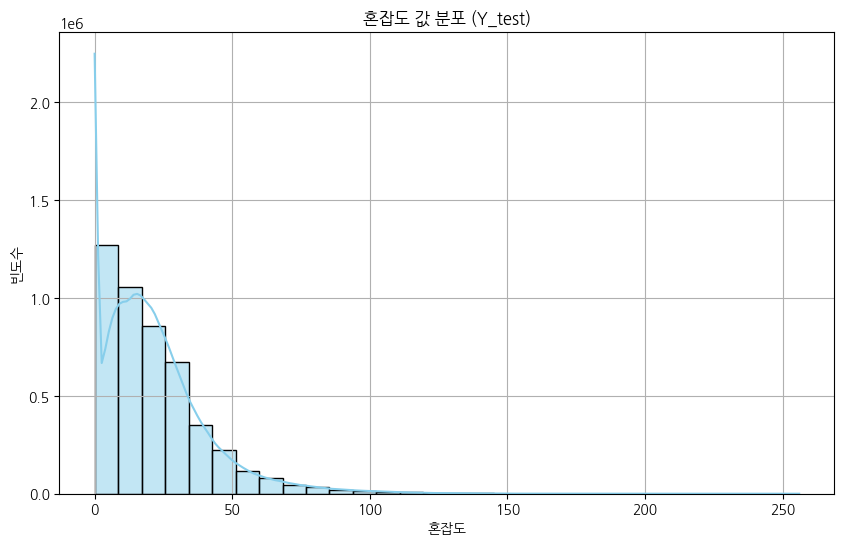

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(Y_test, bins=30, kde=True, color='skyblue')

plt.title('혼잡도 값 분포 (Y_test)')
plt.xlabel('혼잡도')
plt.ylabel('빈도수')
plt.grid(True)
plt.show()

In [16]:
print("혼잡도 (Y_test) 통계 요약:")
print(Y_test.describe())

혼잡도 (Y_test) 통계 요약:
count    4.766902e+06
mean     2.167697e+01
std      1.944923e+01
min      0.000000e+00
25%      8.000000e+00
50%      1.800000e+01
75%      3.000000e+01
max      2.560000e+02
Name: congestion, dtype: float64


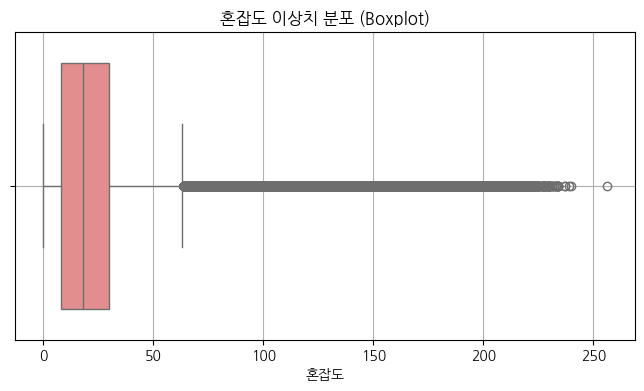

In [17]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=Y_test, color='lightcoral')
plt.title('혼잡도 이상치 분포 (Boxplot)')
plt.xlabel('혼잡도')
plt.grid(True)
plt.show()